In [166]:
!pip install ossapi

  Using cached ossapi-2.2.0-py3-none-any.whl (61 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached osrparse-5.0.0-py3-none-any.whl (10 kB)
  Using cached typing_utils-0.1.0-py3-none-any.whl (10 kB)
  Using cached oauthlib-3.1.1-py2.py3-none-any.whl (146 kB)


In [1]:
# All Imports
import pandas as pd
import csv
import zipfile
import copy
from pythonosu import getStarDifficulty
import os
import csv
from sklearn.feature_selection import SelectPercentile , f_regression, SelectKBest
import seaborn as sns
import matplotlib.pyplot as plt

3.8


In [2]:
# Program Parameters
datasetFolder = "" #redacted
datasetExtension = ".osu"

In [3]:
# OSZ file methods
class OsuZip:

    def __init__(self, filePath):
        self.zipObj = zipfile.ZipFile(filePath,'r')
        self.contentList = self.zipObj.namelist()
        self.readList = []
        self.filterFiles()

    def filterFiles(self):
        tempEviction = []
        for x in self.contentList:
            if datasetExtension not in x:
                tempEviction.append(x)
        for evicted in tempEviction:
            self.contentList.remove(evicted)
        #print(self.contentList,len(self.contentList))

    def getNextOsu(self):
        """Gets Next .osu file in Archive as File Type Object"""
        for x in self.contentList:
            if x not in self.readList:
                self.readList.append(x)
                osuFile = self.zipObj.open(x,'r')
                #print(osuFile.read())
                #return osuFile.read()
                return osuFile
        print("Reached end of List")
        return None

    def resetIter(self):
        """Reset Archive Iterator"""
        self.readList.clear()

    def closeZip(self):
        """Close the Archive File"""
        self.zipObj.close()


In [4]:
#OSU File Methods
#import io

class OsuFile:
    def __init__(self,file):
        self.fileObj = file
        self.fileLines = file.readlines()
        self.features = {}
        self.featureList = ["Song Title","Artist","Creator","Circle Size","Total Notes",
        "Average Interval","Minimum Interval","Maximum Interval","Chords","Notes on Drag","NPM","Difficulty"]
        self.parseFile()

    def parseFile (self):
        """Filters relevant Byte data from file into List of strings containing each line in file"""
        #print(self.fileLines)
        self.hitLines = []
        read = False
        for s in self.fileLines:
            string = s.decode("UTF-8")
            #print(index, string)
            if "Title:" in string:
                self.recordFeature(0,string.split(":")[1].strip())
            if "Artist:" in string:
                self.recordFeature(1,string.split(":")[1].strip())
            if "Creator:" in string:
                self.recordFeature(2,string.split(":")[1].strip())
            if "CircleSize" in string:
                self.recordFeature(3,int(string.split(":")[1].strip()))
                self.totalKeys = self.features[self.featureList[3]]
            
            #if "OverallDifficulty" in string:
            #    self.recordFeature(11,string.split(":")[1].strip())
            if "BeatmapID" in string:
                idValue = int(string.split(":")[1].strip())
                self.recordFeature(11,getStarDifficulty(idValue))
            
            # Mark start of notes
            if "HitObject" in string:
                read = True
            elif read:
                self.hitLines.append(string)
    
    def getFeatures(self):
        return copy.deepcopy(self.features)

    def getFeatureList(self):
        return self.featureList.copy()

    def getTotalKeys(self):
        return self.totalKeys

    def parseData (self):
        """Filters String Lines in file into Features for data selection"""

        # Temp Data Collectors
        timeCount = dict()
        noteCount = dict()
        dragNoteCount = dict()
        prevDragTime = 0
        dragEndTimes = []

        # Simple Features
        self.recordFeature(4,len(self.hitLines))
        averageInterval = 0
        minInterval = 0
        maxInterval = 0

        # Looping Features
        for line in self.hitLines:
            splits = line.split(',')
            timeValue = int(splits[2])
            try:
                dragTimeValue = int(splits[5].split(':')[0])
            except:
                dragTimeValue = 0
                #print("skip")
            # If note occurs after a drag has been finished, remove drag tracking
            while (len(dragEndTimes)>0 and dragEndTimes[0] < timeValue):
                dragEndTimes.pop(0)
            # If drag is starting, track it no matter the condition
            if (dragTimeValue != 0):
                # If a NEW drag timing is added, track previous
                if (len(dragEndTimes)>0 and dragTimeValue > dragEndTimes[(len(dragEndTimes)-1)]):
                    prevDragTime = dragEndTimes[(len(dragEndTimes)-1)]
                dragEndTimes.append(dragTimeValue)
            
            # Ignores notes that start at the same time as a drag. Only counts notes pressed after a drag has started
            if (len(dragEndTimes) > 0 and timeValue > prevDragTime):
                currentDrags = "{}Drag".format(len(dragEndTimes))
                if currentDrags in dragNoteCount:
                    dragNoteCount[currentDrags] += 1
                else:
                    dragNoteCount[currentDrags] = 1
                # Track number of new Drags while drag is ongoing
                if (dragTimeValue != 0):
                    newDragOnDrag = "Drag{}".format(currentDrags)
                    if newDragOnDrag in dragNoteCount:
                        dragNoteCount[newDragOnDrag] += 1
                    else:
                        dragNoteCount[newDragOnDrag] = 1
                
            # Count Notes/Line
            if timeValue in timeCount:
                timeCount[timeValue] += 1
            else:
                timeCount[timeValue] = 1
            # If drag ends in this time frame, remove drag tracking AFTER counting
            while (len(dragEndTimes)>0 and dragEndTimes[0] == timeValue):
                dragEndTimes.pop(0)
        #print(dragNoteCount)
        # Record for Notes hit while drag is ongoing
        self.recordFeature(9,dragNoteCount)
        # Analysis
        timeList = list(timeCount.keys())
        timeList.sort()
        # Record for Notes-Per-Minute
        self.recordFeature(10,len(self.hitLines)/timeList[(len(timeList)-1)]*60000)
        for i in range(0,len(timeList)):
            if i > 0:
                interval = (timeList[i] - timeList[i-1])
                if interval > maxInterval:
                    maxInterval = interval
                if i == 1:
                    minInterval = interval
                elif interval < minInterval:
                    minInterval = interval
                averageInterval += interval
        averageInterval /= float((len(timeList)-1))
        self.recordFeature(5,averageInterval)
        self.recordFeature(6,minInterval)
        self.recordFeature(7,maxInterval)

        for count in timeCount.values():
            if count in noteCount:
                noteCount[count] += 1
            else:
                noteCount[count] = 1
        self.recordFeature(8,noteCount)

    def recordFeature(self,index,value):
        """Shorthand method for adding values to Features dictionary"""
        self.features[self.featureList[index]] = value
    

In [6]:
def tupleizeOsu(features,featureList):
    outputTuple = []
    for i in featureList:
        value = features[i]
        if (i not in featureList[8:10]):
            outputTuple.append(value)
        elif (i == featureList[8]):
            for j in range(1,4):
                if (j in value.keys()):
                    outputTuple.append(value[j])
                else:
                    outputTuple.append(0)
        elif (i == featureList[9]):
            for j in range(1,4):
                currentDrags = "{}Drag".format(j)
                if (currentDrags in value):
                    outputTuple.append(value[currentDrags])
                else:
                    outputTuple.append(0)
            for k in range(1,4):
                currentDrags = "Drag{}Drag".format(k)
                if (currentDrags in value):
                    outputTuple.append(value[currentDrags])
                else:
                    outputTuple.append(0)
    #print(outputTuple)
    return outputTuple

In [7]:
#Read All Files in directory

output = []

# File Limiter (Not in Use)
file_count = 0
package_count = 0
fileLimit = 25
packageLimit = 20

# File Counter

headers = ["Song Title","Artist","Creator","Circle Size","Total Notes",
        "Average Interval","Minimum Interval","Maximum Interval","2 Chord",
        "3 Chord", "4 Chord","1 Note on Drag","2 Note on Drag","3 Note on Drag",
        "Drag on 1 Drag","Drag on 2 Drag","Drag on 3 Drag","NPM","Difficulty"]

f = open("output.csv",'w')
writer = csv.writer(f)
writer.writerow(headers)

for file in os.listdir(datasetFolder):
    print(file)
    testClass = OsuZip("{}{}".format(datasetFolder,file))
    testFile = testClass.getNextOsu()
    current_file_count = 0
    package_count += 1
    while testFile is not None:
        try:
            current_file_count +=1
            fileClass = OsuFile(testFile)
            # TODO: Before Parsing, check for 4K
            if (fileClass.getTotalKeys() == 4):
                fileClass.parseData()
                #print(fileClass.getFeatures())
                #output.append(tupleizeOsu(fileClass.getFeatures(),fileClass.getFeatureList()))
                tupled_out = tupleizeOsu(fileClass.getFeatures(),fileClass.getFeatureList())
                writer.writerow(tupled_out)
        except:
            print("Error from file "+file)
            current_file_count -= 1
        finally:
            testFile = testClass.getNextOsu()
    testClass.closeZip()
    if current_file_count == 0:
        package_count -= 1
    file_count += current_file_count
    #if (fileCount >= fileLimit):
    #    break
#print(output)
f.close()
print("Total Zips: {}, Total BeatMaps: {}".format(package_count,file_count))

100501 Tamura Yukari - Fantastic future (TV Size).osz
Reached end of List
102519 KOTOKO - unfinished (TV Size).osz
Reached end of List
103550 Leon Lai - Zhong Ai Qing You (Speed up Version).osz
Reached end of List
103856 fripSide - fortissimo -the ultimate crisis-.osz
Reached end of List
104030 Ushirokara Haiyoritai G - Koi wa Chaos no Shimobenari (TV Size).osz
Reached end of List
104151 Anamanaguchi - STILL SPLODIN' THO (Interlude).osz
Reached end of List
104839 fripSide - fortissimo-from insanity affection- (Short Ver.).osz
Reached end of List
105186 Baauer - Harlem Shake.osz
Reached end of List
106040 Aoi Eir - INNOCENCE (TV Size).osz
Reached end of List
106212 LeaF - MEPHISTO.osz
Reached end of List
106740 Dormir - Sayonara Trip.osz
Reached end of List
107009 Shouta Kageyama - Relic Song.osz
Reached end of List
107781 Suzaku - Anisakis -somatic mutation type -Forza--.osz
Reached end of List
107796 yoshiki-lisa - Destin Histoire (TV Size).osz
Reached end of List
108577 fripSide - et

In [10]:
data = pd.read_csv("output.csv",header=0)
print("Unique Values {}".format(data["Song Title"].nunique()))
data

Unique Values 480


,Song Title,Artist,Creator,Circle Size,Total Notes,Average Interval,Minimum Interval,Maximum Interval,2 Chord,3 Chord,4 Chord,1 Note on Drag,2 Note on Drag,3 Note on Drag,Drag on 1 Drag,Drag on 2 Drag,Drag on 3 Drag,NPM,Difficulty
0,Fantastic future (TV Size),Tamura Yukari,victorica_db,4,538,209.468900,87,959,301,117,1,119,5,0,19,4,0,366.984993,2.41
1,Fantastic future (TV Size),Tamura Yukari,victorica_db,4,825,161.248619,87,523,293,222,28,323,33,11,47,5,2,562.755798,3.48
2,Fantastic future (TV Size),Tamura Yukari,victorica_db,4,319,329.165414,174,1744,215,52,0,32,1,0,15,1,0,217.598909,1.55
3,unfinished (TV Size),KOTOKO,ljqandylee,4,744,155.093817,68,1233,261,144,65,0,0,0,0,0,0,606.587673,3.18
4,unfinished (TV Size),KOTOKO,ljqandylee,4,223,333.665138,205,1233,215,4,0,0,0,0,0,0,0,181.813241,1.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813,Flip Flap,kors k,HanzeR,4,295,342.857143,57,5486,295,0,0,2,0,0,2,0,0,162.252839,4.76
1814,Flip Flap,kors k,HanzeR,4,289,352.381944,114,5486,289,0,0,2,0,0,2,0,0,157.959463,3.59
1815,You & Me,Tamura Yukari ft motsu from m.o.v.e,- R u m i a -,4,600,421.195652,187,3000,506,47,0,43,0,0,22,0,0,154.182852,1.27
1816,You & Me,Tamura Yukari ft motsu from m.o.v.e,- R u m i a -,4,724,364.143975,94,2625,556,84,0,65,0,0,30,0,0,186.047308,1.50


In [4]:
headers = ["Song Title","Artist","Creator","Circle Size","Total Notes",
        "Average Interval","Minimum Interval","Maximum Interval","2 Chord","3 Chord", "4 Chord","1 Note on Drag","2 Note on Drag","3 Note on Drag","Drag on 1 Drag","Drag on 2 Drag","Drag on 3 Drag","NPM","Difficulty"]

for key in headers:
    data[key] = pd.Categorical(data[key])
    data[key] = data[key].cat.codes

In [14]:

allXValues = data.loc[:,((data.columns != "Difficulty")&(data.columns != "Circle Size")&(data.columns !="Song Title")&(data.columns != "Creator"))]
yValues = data["Difficulty"]
selectFeature = SelectKBest(score_func=f_regression)
bestKX = selectFeature.fit(allXValues,yValues)
scoreFrame = pd.DataFrame({"Name":allXValues.columns,"Scores":bestKX.scores_})
sortFrame = scoreFrame.sort_values(by=["Scores"],ascending=False)
display(sortFrame)


,Name,Scores
2,Average Interval,1263.908457
3,Minimum Interval,1129.684997
1,Total Notes,887.010230
14,NPM,847.652046
5,2 Chord,658.862910
7,4 Chord,580.224518
6,3 Chord,343.962237
8,1 Note on Drag,74.231760
9,2 Note on Drag,53.928551
12,Drag on 2 Drag,28.443161


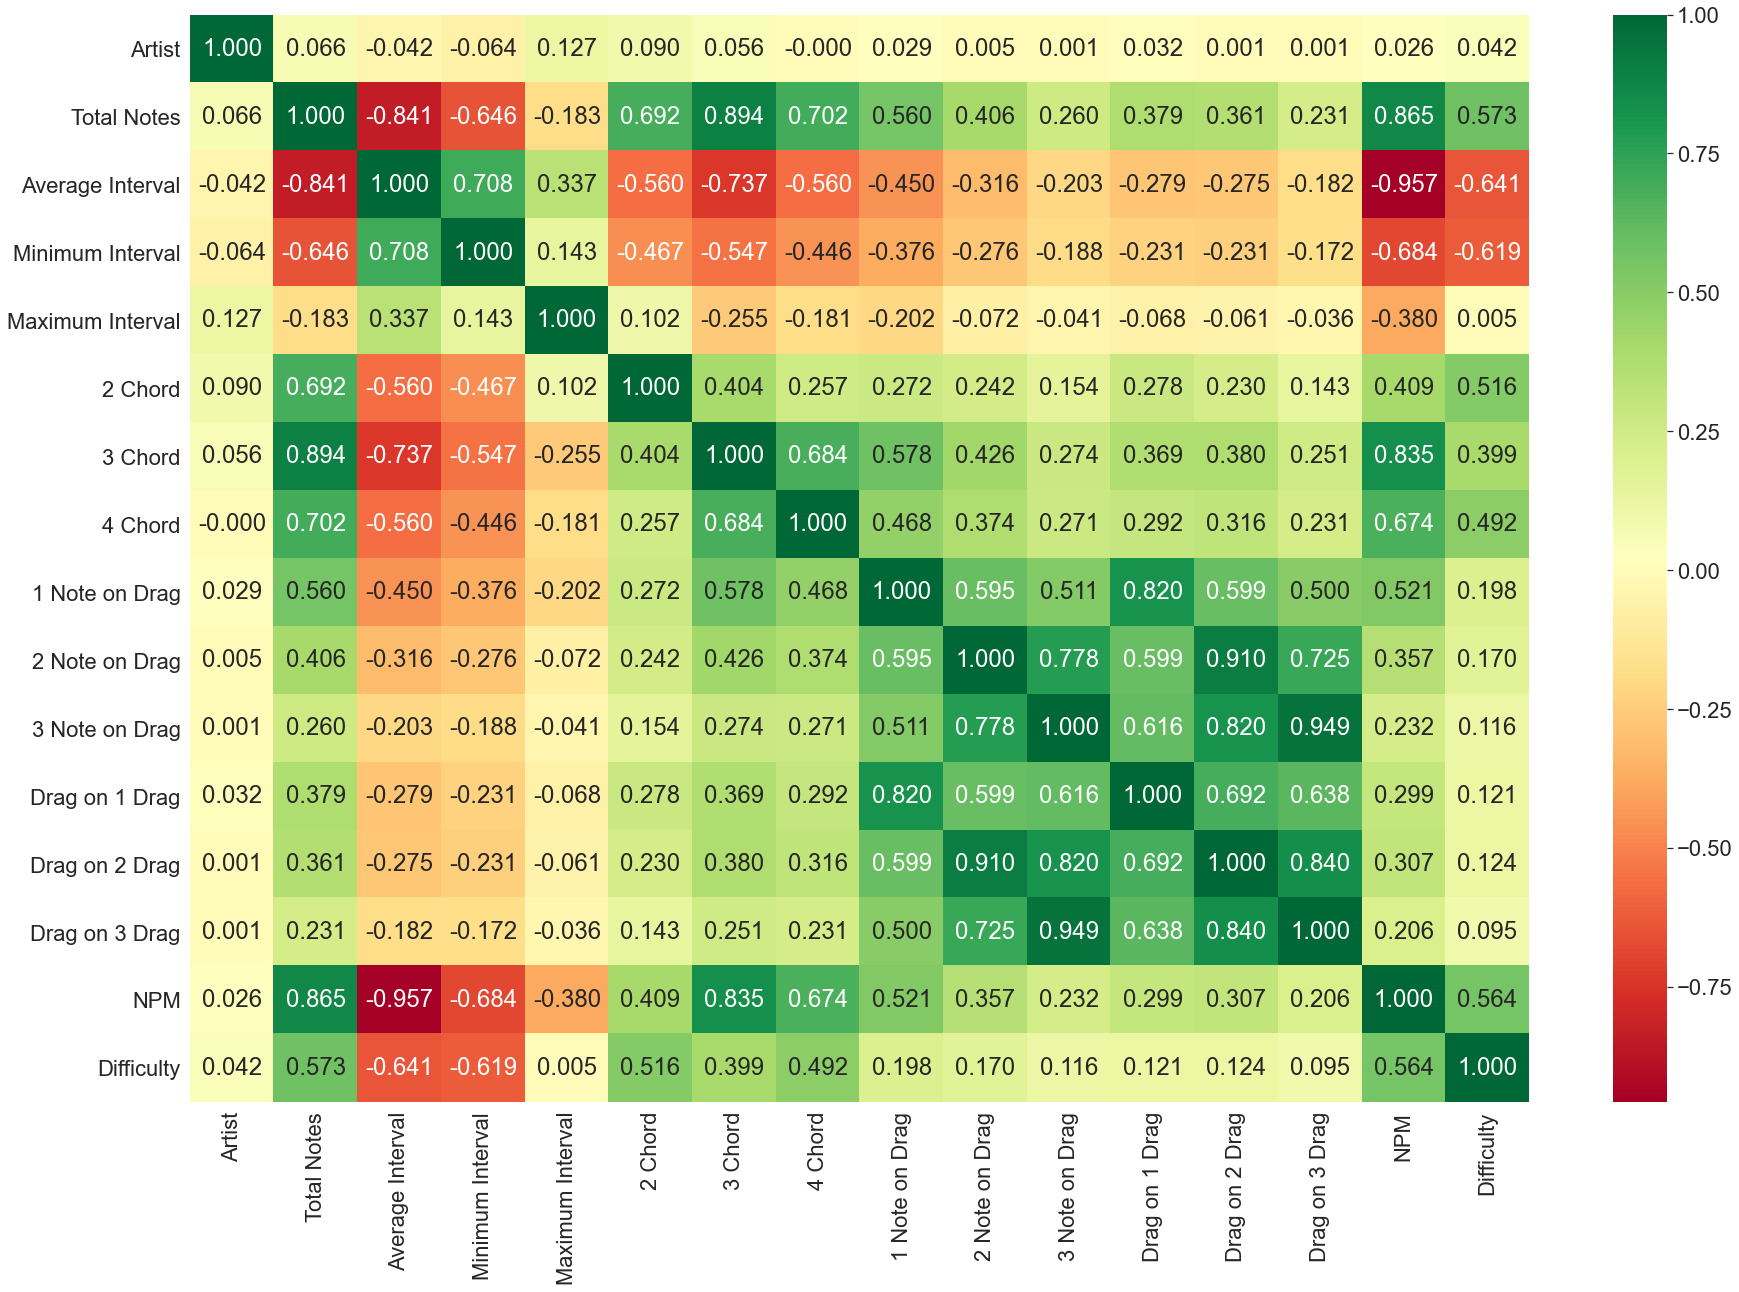

In [15]:
# REF: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
corrmat = data.loc[:,((data.columns != "Circle Size")&(data.columns !="Song Title")&(data.columns != "Creator"))].corr()
topCorr = corrmat.index
plt.figure(figsize=(30,20))
sns.set(font_scale = 2)
g=sns.heatmap(data[topCorr].corr(),annot=True,fmt=".3f",cmap="RdYlGn")
plt.savefig('export.png')